# Discrete Flow Matching


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1BnGVmUK9hU9HVK42JbQBF2l-7rbAZ0yu?usp=sharing)

_notebook by Georges Le Bellier_  - [Twitter](https://twitter.com/_lebellig), [Website](https://gle-bellier.github.io)

This is an unofficial implementation of the paper made [Discrete Flow Matching](https://arxiv.org/abs/2407.15595#) by Itai Gat et al [1]. This notebook has an educational purpose and explores the case of discrete image generation. We strongly encourage the readers to check the whole framework in the original paper and we report the formula with their indexes in the paper.
## References:

📄 [1] **Discrete Flow Matching** by Itai Gat, Tal Remez, Neta Shaul, Felix Kreuk, Ricky T. Q. Chen, Gabriel Synnaeve, Yossi Adi, Yaron Lipman - [Article](https://arxiv.org/abs/2407.15595#)

📄 [2] **Generative Flows on Discrete State-Spaces: Enabling Multimodal Flows with Applications to Protein Co-Design** by Andrew Campbell, Jason Yim, Regina Barzilay, Tom Rainforth, Tommi Jaakkola [Article](https://arxiv.org/abs/2402.04997)

📄 [3] **Flow Matching for Generative Modeling** by Yaron Lipman, Ricky T. Q. Chen, Heli Ben-Hamu, Maximilian Nickel, Matt Le - [Article](https://arxiv.org/abs/2210.02747)

🐍 [4] **Introduction to Flow Matching** by Georges Le Bellier - [Notebook](https://github.com/gle-bellier/flow-matching/tree/main)


## Flow Matching:
The flow matching framework can be summaries as follow:

I) At training time:

  1. Build pairs of $x_0$ and $x_1$, i.e. sample $(x_0, x_1) \sim p(x_0, x_1)$ (in the independant case $p(x_0, x_1) = p(x_0)p(x_1)$.
  2. Sample $x_t \sim p( . | x_0, x_1)$, i.e. interpolating between $x_0$ and $x_1$
  3. Regress $u(t, x_t)$ the velocity vector at $x_t$ and time $t$ with a neural network.

II) At sampling time:
  1. Sample $x_0 \sim p_0$
  2. Follow the flow described by the velocity vector $u(t, x_t)$ until $t=1$.
    
_Discrete flow matching_ shares the same steps but adapts them to discrete data.

In [1]:
#@title ⚠️ TODO: imports
%%capture
!git clone https://github.com/gle-bellier/discrete-fm.git
!cp -r discrete-fm/* . && rm -r discrete-fm
# imports
!pip install lightning
!pip install einops

from __future__ import annotations
from torch import nn
from torch.nn import functional as F
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import os

import torch
from einops import rearrange
import matplotlib.pyplot as plt
from typing import Tuple, List

from datamodule import DigitDataModule
from unet import SongUnet
from utils import create_animation, plot_generation


Prob = torch.Tensor
Img = torch.Tensor

def pad_like_x(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    # add dims to x to match number of dims in y
    return x.reshape(-1, *(1 for _ in range(y.ndim - x.ndim)))



##1.0 Useful tools:

Instead of working on image data (`Img` type), most of the steps of the discrete flow matching deal with class probability distributions (`Prob` type). Thus, we need a function `x2prob` that converts image data into its class distribution representation (one-hot-encoding) and the reciprocal `sample_p` that samples an image from the class probability distribution.

In [2]:
def x2prob(x: Img, dict_size: int) -> Prob:
    x = torch.nn.functional.one_hot(x, num_classes=dict_size)
    return rearrange(x, 'b h w c -> b c h w')

def sample_p(pt: Prob) -> Img:
    b, _, h, w = pt.shape
    pt = rearrange(pt, 'b c h w -> (b h w) c')
    xt = torch.multinomial(pt, 1)
    return xt.reshape(b, h, w)

## I.1. Couplings, building $x_0, x_1$ pairs:

This article considers discrete data, meaning the data can take a finite number of values. For images, we can see these values as classes between 0 and 255. In addition to the values taken by the data points, the article adds another symbol to the dictionary: the mask $m$. This extra token is used to _corrupt_ the data.
Now we need to build the coupling required for the training:



In [3]:
class Coupling:
    def __init__(self) -> None:
        pass

    def sample(self, x1: Img) -> tuple[Img, Img]:
        raise NotImplementedError

__Unconditional__ coupling:
In this case, $p_0$ and $p_1$ are independent. $p_1$ is the data distribution (e.g. images, text), and $p_0 = \delta_m$ i.e. its samples are data composed only of the mask token. We will use this coupling in this notebook.

$$  (X_0,X_1) = \Big((m,\ldots,m),X_1\Big), \tag{4} $$


In [4]:
class Ucoupling(Coupling):
    def __init__(self) -> None:
        pass

    def sample(self, x1: Img) -> tuple[Img, Img]:
        return torch.zeros_like(x1), x1

__Conditional__ coupling: this time, $X_0$ is a partially corrupted version of $X_1$ with the mask token (it is a masked version of the data point):

$$ (X_0,X_1) = (I \odot X_1  + (1-I)\odot (m,\ldots,m) , X_1) \tag{5} $$

In [5]:
class Ccoupling(Coupling):
    def __init__(self, msk_prop: float = 0.8) -> None:
        self.msk_prob = msk_prop

    def sample(self, x1: Img) -> tuple[Img, Img]:
        # sample mask
        I = torch.rand_like(x1.float()) > self.msk_prob
        x0 = x1 * I + torch.zeros_like(x1) * (~I)
        return x0, x1

## I.2. Interpolation via scheduler

In the flow matching framework, we interpolate between $x_0$ and $x_1$ via an interpolant (here named scheduler). In continuous space, we can use classic interpolation techniques (linear, cosine...), e.g.
$$
    x_t = (1 - t)x_0 + tx_1
$$
Nevertheless, we can not do the same in discrete spaces as such $x_t$ values might not belong to the discrete dictionary. Instead, to build $x_t$, we will first interpolate the class distributions w.r.t the scheduler $\kappa_t$ and then sample $x_t$ from it.
$$
p_t(x^i|x_0,x_1) = (1-\kappa_t)\delta_{x_0}(x^i) + \kappa_t \delta_{x_1}(x^i)
\text{  and  } x_t \sim p_t(x^i|x_0, x_1) \tag{9}
$$

Here both $\delta_{x_0}$ and $\delta_{x_1}$ are represented as one-hot encoded versions of $x_0$ and $x_1$ and we are interpolating between them with the scheduler $\kappa_t$.



In [6]:
class KappaScheduler:
    def __init__(self) -> None:
        pass
For
    def __call__(self, t: float | torch.Tensor) ->  float | torch.Tensor:
        raise NotImplementedError

    def derivative(self, t: float | torch.Tensor) -> float | torch.Tensor:
        raise NotImplementedError

class CubicScheduler(KappaScheduler):
    def __init__(self, a: float = 2.0, b: float = 0.5) -> None:
        self.a = a
        self.b = b

    def __call__(self, t: float | torch.Tensor) -> float | torch.Tensor:
        return -2* (t**3) + 3 * (t**2) + self.a * (t ** 3 - 2* t**2 + t) + self.b * (t**3 - t**2)

    def derivative(self, t: float | torch.Tensor) -> float | torch.Tensor:
        return -6 * (t**2) + 6 * t + self.a * (3 * t**2 - 4 * t + 1) + self.b * (3 * t**2 - 2 * t)


In [7]:
def sample_cond_pt(p0: Prob, p1: Prob, t: torch.Tensor | float, kappa: KappaScheduler) -> Img:
    t = t.reshape(-1, 1, 1, 1)
    pt = (1 - kappa(t)) * p0 + kappa(t) * p1
    return sample_p(pt)

## I.3. Velocity regression

Now we want to learn the velocity vector $u$ for all times between 0 and 1. This vector is also called _forward velocity_ as it guides the forward process, i.e. going from $p$ to $q$ (from full mask to the data distribution). We have an explicit formula for the forward velocity:
$$ u^i_t(x^i,z) = \frac{\dot{\kappa}_t}{1-\kappa_t}[p_{1|t}(x^i|z) - \delta_{z} (x^i)] \tag{26} $$




In [8]:
    def forward(self, t: float | torch.Tensor, x: Img) -> Img:
        return self.backbone(t, x)

    def forward_u(self, t: float | torch.Tensor, xt: Img) -> Prob:
        dirac_xt = x2prob(xt, self.dict_size)
        p1t = torch.softmax(self(t.flatten(), xt), dim=1)
        kappa_coeff = self.kappa.derivative(t) / (1 - self.kappa(t))

        return kappa_coeff * (p1t - dirac_xt)

In addition to the forward velocity, one may want to learn the _backward velocity_ associated with the backward process (from data distribution to full mask in our case).
Backward velocity:

$$  \check{u}_t^i(x^i,z)=\frac{\dot{\kappa}_t}{\kappa_t}[\delta_{z}(x^i) - p_0(x^i)] \tag{27}$$

In [9]:
    def backward_u(self, t: float | torch.Tensor, xt: Img) -> Prob:
        dirac_xt = x2prob(xt, self.dict_size)

        # TODO: adapt to Ccoupling
        x0 = torch.zeros_like(xt)
        p = x2prob(x0, self.dict_size)

        kappa_coeff = self.kappa.derivative(t) / self.kappa(t)
        return kappa_coeff * (dirac_xt - p)


Fortunately, in our case, $p_0$ is the distribution of the full mask, we only need to achieve the __denoising objective__, namely learning $p_{1|t}(x^i|z)$. The more general loss function depicted in the article:
$$
    \mathcal{L}(\theta) = -\sum_{j\in [m],i\in [N]}\mathbb{E}_{t,(X_0,X_1),X_t,Y_j^i} \log \hat{w}_{t}^{j}(Y_j^i|X_t;\theta) \tag{28}
$$
then becomes:
$$
    \mathcal{L}(\theta) = -\sum_{i\in [N]}\mathbb{E}_{t,(X_0,X_1),X_t} \log \hat{p}_{1|t}(X_1^i|X_t;\theta)
$$

⛳ To summarize, this is a classification task: given $X_t$, a partially mask-corrupted version of $X_1$, the model $\hat{p}_{1|t}(⋅|X_t;\theta)$ has to predict the class distribution of the true data $X_1$.

In [10]:
    def step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # sample x0, x1 w.r.t. coupling
        x0, x1 = self.coupling.sample(batch[0])

        # sample t ~ U[0, 1]
        t = torch.rand(len(x0), device=self.device)

        # sample pt(.|x0, x1)
        dirac_x0 = x2prob(x0, self.dict_size)
        dirac_x1 = x2prob(x1, self.dict_size)
        xt = sample_cond_pt(dirac_x0, dirac_x1, t, self.kappa)

        # predict p1|t, i.e. (VF - Denoiser)
        p1t = self(t, xt)
        loss = F.cross_entropy(p1t, x1.long())
        return loss

In [11]:
#@title ⏳ Summary: please run this cell which contains the ```DiscreteFM``` class

class DiscreteFM(L.LightningModule):
    def __init__(self, dict_size: int,  backbone: nn.Module, coupling: Coupling, kappa: KappaScheduler) -> None:
        super().__init__()
        self.dict_size = dict_size
        self.backbone = backbone
        self.coupling = coupling
        self.kappa = kappa

    def forward(self, t: float | torch.Tensor, x: Img) -> Img:
        return self.backbone(t, x)

    def forward_u(self, t: float | torch.Tensor, xt: Img) -> Prob:
        dirac_xt = x2prob(xt, self.dict_size)
        p1t = torch.softmax(self(t.flatten(), xt), dim=1)

        kappa_coeff = self.kappa.derivative(t) / (1 - self.kappa(t))
        return kappa_coeff * (p1t - dirac_xt)

    def backward_u(self, t: float | torch.Tensor, xt: Img) -> Prob:
        dirac_xt = x2prob(xt, self.dict_size)

        # TODO: adapt to Ccoupling
        x0 = torch.zeros_like(xt)
        p = x2prob(x0, self.dict_size)

        kappa_coeff = self.kappa.derivative(t) / self.kappa(t)
        return kappa_coeff * (dirac_xt - p)

    def bar_u(self, t: float | torch.Tensor, xt: Img, alpha_t: float | torch.Tensor, beta_t: float | torch.Tensor) -> Prob:
        return alpha_t * self.forward_u(t, xt) - beta_t * self.backward_u(t, xt)

    def step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # sample x0, x1 w.r.t. coupling
        x0, x1 = self.coupling.sample(batch[0])

        # sample t ~ U[0, 1]
        t = torch.rand(len(x0), device=self.device)

        # sample pt(.|x0, x1)
        dirac_x0 = x2prob(x0, self.dict_size)
        dirac_x1 = x2prob(x1, self.dict_size)
        xt = sample_cond_pt(dirac_x0, dirac_x1, t, self.kappa)

        # predict p1|t, i.e. (VF - Denoiser)
        p1t = self(t, xt)
        loss = F.cross_entropy(p1t, x1.long())
        return loss

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        loss = self.step(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        loss = self.step(batch)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-4)

# I.4 Training

Please uncomment the `trainer.fit` line to train the model and `torch.save` to save your own checkpoint (otherwise it will load a pre-trained model for the sampling section of the notebook). We train a discrete flow model on quantized 32x32 MNIST images (`DICT_SIZE`-1 values possible). The extra token is directly added in the Dataset `__getitem__`.

In [13]:
DICT_SIZE = 10
MODEL_CHANNELS = 64
unet =  SongUnet(img_resolution = 32,
    in_channels = 1,
    out_channels = DICT_SIZE,
    model_channels= MODEL_CHANNELS)
coupling = Ucoupling()
kappa = CubicScheduler()


discretefm = DiscreteFM(DICT_SIZE, unet, coupling, kappa)
dm = DigitDataModule(dict_size=DICT_SIZE, batch_size=200)
dm.setup()
trainer = L.Trainer(max_epochs=1, logger=TensorBoardLogger('lightning_logs'), devices=1)

# UNCOMMENT HERE TO TRAIN MODEL
trainer.fit(discretefm, dm)


# # save model
# save_path = f'discretefm-{MODEL_CHANNELS}.pt'
# torch.save(discretefm.state_dict(), save_path)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type     | Params | Mode 
----------------------------------------------
0 | backbone | SongUnet | 15.5 M | train
----------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
61.918    Total estimated model params size (MB)
318       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


# II. Generation / Sampling

For sampling, we start from a sample of $p_0$ (in our case $\delta_m$) and then follow the flow described by the learned velocity $u$. Then, the update rule is:

$$ X^i_{t+h} \sim \delta_{X^i_t}(\cdot) + h u_t^i(\cdot,X_t) \tag{12} $$

Starting from the one-hot encoding of $X_t$, at each timestep, the velocity updates the class probability distribution __and__ we sample from the updated distribution to get the new $X_{t+h}$. Hence, the sampling is stochastic.
Please refer to the original article (and its annexes) for more details about the samplers used, in particular the corrector sampler.  

In [17]:
#@title ⏳ Summary: please run this cell which contains the ```DiscreteSampler``` class

class DiscreteSampler:
    def __init__(self, adaptative: bool = True) -> None:
        self.h = self.adaptative_h if adaptative else self.constant_h


    def u(self, t: float | torch.Tensor, xt: Img, discretefm: DiscreteFM) -> Prob:
        raise NotImplementedError

    def adaptative_h(self, h: float | torch.Tensor, t: float | torch.Tensor,  discretefm: DiscreteFM) -> float | torch.Tensor:
        raise NotImplementedError

    def constant_h(self, h: float | torch.Tensor, t: float | torch.Tensor,  discretefm: DiscreteFM) -> float | torch.Tensor:
        return h

    def sample_x0(self, sample_size: Tuple[int], device: torch.device, dict_size: int) -> Tuple[Img, Prob]:
        x0 = torch.zeros(sample_size, device=device, dtype=torch.long)
        dirac_x0 = x2prob(x0, dict_size)

        return x0, dirac_x0

    def __call__(self, sample_size: Tuple[int], discretefm: DiscreteFM, n_steps: int, t_min: float = 1e-4) -> List[Img]:

        t = t_min * torch.ones(sample_size[0], device=discretefm.device)
        default_h = 1 / n_steps
        # sample initial x0
        xt, dirac_xt = self.sample_x0(sample_size, discretefm.device, discretefm.dict_size)

        list_xt = [xt]
        t = pad_like_x(t, dirac_xt)

        while t.max() <= 1 - default_h:
            h = self.h(default_h, t, discretefm)
            pt = dirac_xt + h * self.u(t, xt, discretefm)
            # sample xt
            xt = sample_p(pt)
            dirac_xt = x2prob(xt, discretefm.dict_size)
            t += h
            list_xt.append(xt)

        return list_xt

class SimpleSampler(DiscreteSampler):

    def u(self, t: float | torch.Tensor, xt: Img, discretefm: DiscreteFM) -> Prob:
        return discretefm.forward_u(t, xt)

    def adaptative_h(self, h: float | torch.Tensor, t: float | torch.Tensor, discretefm: DiscreteFM) -> float | torch.Tensor:

        coeff = (1 - discretefm.kappa(t)) / discretefm.kappa.derivative(t)
        h = torch.tensor(h, device=discretefm.device)
        h_adapt = torch.minimum(h, coeff)
        return h_adapt

class CorrectorSampler(DiscreteSampler):
    def __init__(self, adaptative: bool = True, alpha: float = 12., a: float = 2.,  b: float = 0.25) -> None:
        super().__init__(adaptative)
        # best hyperparameters for image generation (w.r.t. the paper)
        self.alpha = alpha
        self.a, self.b = a, b
        self.alpha_t = lambda t: 1 + (self.alpha * (t ** self.a)) * ((1 - t) ** self.b)
        self.beta_t = lambda t: self.alpha_t(t) - 1

    def u(self, t: float | torch.Tensor, xt: Img, discretefm: DiscreteFM) -> Prob:
        return discretefm.bar_u(t, xt, self.alpha_t(t), self.beta_t(t))

    def adaptative_h(self, h: float | torch.Tensor, t: float | torch.Tensor, discretefm: DiscreteFM) -> float | torch.Tensor:

        alpha_term = self.alpha_t(t) * discretefm.kappa.derivative(t) / (1 - discretefm.kappa(t))
        beta_term = self.beta_t(t) * discretefm.kappa.derivative(t) / discretefm.kappa(t)
        coeff = 1 / (alpha_term + beta_term)

        h = torch.tensor(h, device=discretefm.device)
        h_adapt = torch.minimum(h, coeff)
        return h_adapt

In [18]:
# load model
MODEL_CHANNELS = 64
load_path = f'discretefm-{MODEL_CHANNELS}.pt'
unet =  SongUnet(img_resolution = 32,  # Image resolution at input/output.
    in_channels = 1,
    out_channels = DICT_SIZE,
    model_channels= MODEL_CHANNELS)
coupling = Ucoupling()
kappa = CubicScheduler()
sampler = SimpleSampler()
discretefm = DiscreteFM(DICT_SIZE, unet, coupling, kappa)
discretefm.load_state_dict(torch.load(load_path))
discretefm.eval()

# put discretefm on gpu (if available) for faster sampling
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discretefm.to(device)

DiscreteFM(
  (backbone): SongUnet(
    (map_noise): PositionalEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Lin

In [19]:
sample_size = (16, 32, 32)
N_STEPS = 1024
#sampler = SimpleSampler(adaptative=True)
sampler = CorrectorSampler(adaptative=True)
with torch.no_grad():
    xts = sampler(sample_size, discretefm, N_STEPS)

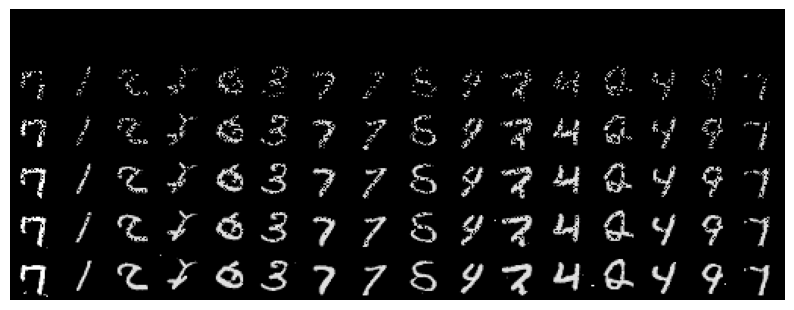

In [20]:
plot_generation(xts, n_plots=5)

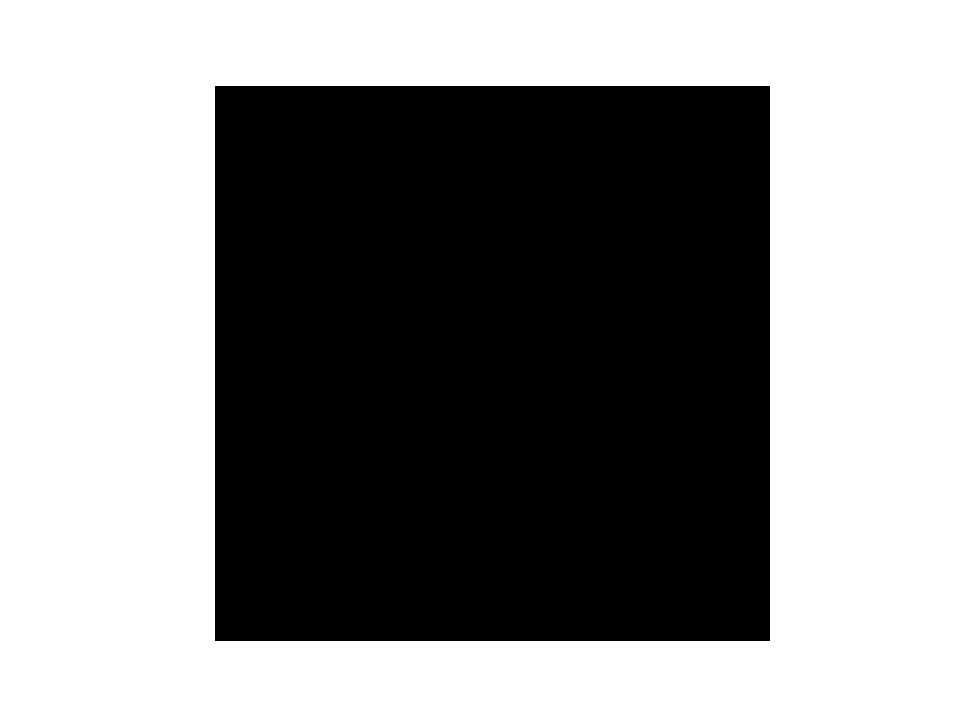

In [21]:
create_animation(xts, 'digits.gif', duration=5, dict_size=DICT_SIZE)
from IPython.display import Image
Image(open('digits.gif','rb').read())